In [137]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import os

In [138]:
# Lecture de la base de données

# Construire le chemin d'accès au dataset
script_dir = "C:/Users/wwway/Downloads/prediction-of-TGV-delays-main/prediction-of-TGV-delays-main"
relative_path = 'dataset/regularite-mensuelle-tgv-aqst.csv'
csv_path = os.path.join(script_dir, relative_path)

# Chargez le fichier CSV
data = pd.read_csv(csv_path, delimiter=";")
gares_info = pd.read_csv("C:/Users/wwway/Downloads/liste-des-gares.csv", delimiter=";")
gares_frequentation = pd.read_csv("C:/Users/wwway/Downloads/frequentation-gares.csv", delimiter=";")
print(data.head(6))
# Transformer lea colonne date en datetime
df = data
df["date"]= pd.to_datetime(df["date"])

      date   service         gare_depart         gare_arrivee  duree_moyenne  \
0  2018-01  National    BORDEAUX ST JEAN   PARIS MONTPARNASSE            141   
1  2018-01  National   LA ROCHELLE VILLE   PARIS MONTPARNASSE            165   
2  2018-01  National  PARIS MONTPARNASSE              QUIMPER            220   
3  2018-01  National  PARIS MONTPARNASSE              ST MALO            156   
4  2018-01  National  PARIS MONTPARNASSE  ST PIERRE DES CORPS             61   
5  2018-01  National             QUIMPER   PARIS MONTPARNASSE            223   

   nb_train_prevu  nb_annulation  commentaire_annulation  \
0             870              5                     NaN   
1             222              0                     NaN   
2             248              1                     NaN   
3             102              0                     NaN   
4             391              2                     NaN   
5             256              1                     NaN   

   nb_train_depart

In [139]:
# Convert both columns to lowercase for a case-insensitive comparison
data['gare_depart_lower'] = data['gare_depart'].str.lower()
gares_frequentation['Nom de la gare_lower'] = gares_frequentation['Nom de la gare'].str.lower()

# Filter and update the 'gares_frequentation' DataFrame
filtered_gares_frequentation = gares_frequentation[gares_frequentation['Nom de la gare_lower'].isin(data['gare_depart_lower'])]

# Replace the 'Nom de la gare' column with the original case-sensitive names from 'data'
filtered_gares_frequentation['Nom de la gare'] = filtered_gares_frequentation['Nom de la gare_lower'].apply(lambda x: data['gare_depart'].loc[data['gare_depart_lower'] == x].values[0])

# Remove the lowercase columns, if needed
filtered_gares_frequentation = filtered_gares_frequentation.drop(columns=['Nom de la gare_lower'])

# Now, 'filtered_gares_frequentation' contains only the rows with station names from 'data' and updated names.
print(f"On a pas d'informations sur ",len([f for f  in data['gare_depart'].unique() if f not in filtered_gares_frequentation["Nom de la gare"].unique()]), " sur ",len(data['gare_depart_lower'].unique()), " gares TGV")
try :
    data= data.drop(columns=['gare_depart_lower'])
except: pass


On a pas d'informations sur  10  sur  59  gares TGV


C:\Users\wwway\AppData\Local\Temp\ipykernel_12024\3234067399.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_gares_frequentation['Nom de la gare'] = filtered_gares_frequentation['Nom de la gare_lower'].apply(lambda x: data['gare_depart'].loc[data['gare_depart_lower'] == x].values[0])


# Ajouter les données de fréquentation à notre dataset 


In [140]:
passenger_data = filtered_gares_frequentation

# Pour chaque année dans notre dataset on va ajouter les informations sur la fréquentation des passagers
# Cependant notre passenger_data ne contient pas les informations sur l'année 2023
for annee in ["2018", "2019", "2020", "2021", "2022"]:
    # Fusionner les données des voyageurs pour 'Total Voyageurs' pour l'année spécifiée
    data['Total Voyageurs ' + annee] = data.apply(
        lambda ligne: passenger_data[
            (passenger_data['Nom de la gare'] == ligne['gare_depart'])][f'Total Voyageurs {annee}'].values[0]
        if not passenger_data[(passenger_data['Nom de la gare'] == ligne['gare_depart'])].empty
        else None, axis=1
    )

    # Fusionner les données des voyageurs pour 'Total Voyageurs + Non voyageurs' pour l'année spécifiée
    data['Total Voyageurs + Non voyageurs ' + annee] = data.apply(
        lambda ligne: passenger_data[
            (passenger_data['Nom de la gare'] == ligne['gare_depart'])][f'Total Voyageurs + Non voyageurs {annee}'].values[0]
        if not passenger_data[(passenger_data['Nom de la gare'] == ligne['gare_depart'])].empty
        else None, axis=1
    )

# Afficher les premières lignes des données
data.head()


date   service         gare_depart         gare_arrivee  \
0 2018-01-01  National    BORDEAUX ST JEAN   PARIS MONTPARNASSE   
1 2018-01-01  National   LA ROCHELLE VILLE   PARIS MONTPARNASSE   
2 2018-01-01  National  PARIS MONTPARNASSE              QUIMPER   
3 2018-01-01  National  PARIS MONTPARNASSE              ST MALO   
4 2018-01-01  National  PARIS MONTPARNASSE  ST PIERRE DES CORPS   

   duree_moyenne  nb_train_prevu  nb_annulation  commentaire_annulation  \
0            141             870              5                     NaN   
1            165             222              0                     NaN   
2            220             248              1                     NaN   
3            156             102              0                     NaN   
4             61             391              2                     NaN   

   nb_train_depart_retard  retard_moyen_depart  ...  Total Voyageurs 2018  \
0                     289            11.247809  ...            16080989.0   
1                       8             2.875000  ...             1984267.0   
2                      37             9.501351  ...            59174533.0   
3                      12            19.912500  ...            59174533.0   
4                      61             7.796995  ...            59174533.0   

   Total Voyageurs + Non voyageurs 2018  Total Voyageurs 2019  \
0                            19853073.0            17675655.0   
1                             2511730.0             2235983.0   
2                            73296351.0            61374056.0   
3                            73296351.0            61374056.0   
4                            73296351.0            61374056.0   

   Total Voyageurs + Non voyageurs 2019  Total Voyageurs 2020  \
0                            21821796.0            11184093.0   
1                             2830359.0             1490951.0   
2                            76622775.0            32447396.0   
3                            76622775.0            32447396.0   
4                            76622775.0            32447396.0   

  Total Voyageurs + Non voyageurs 2020  Total Voyageurs 2021  \
0                           13807523.0            16454662.0   
1                            1887280.0             2059413.0   
2                           40623410.0            41039816.0   
3                           40623410.0            41039816.0   
4                           40623410.0            41039816.0   

   Total Voyageurs + Non voyageurs 2021  Total Voyageurs 2022  \
0                            20314398.0            21353889.0   
1                             2606852.0             2692269.0   
2                            51402955.0            56862435.0   
3                            51402955.0            56862435.0   
4                            51402955.0            56862435.0   

   Total Voyageurs + Non voyageurs 2022  
0                            26362827.0  
1                             3407936.0  
2                            71219734.0  
3                            71219734.0  
4                            71219734.0  

[5 rows x 36 columns]

In [141]:
data["Total Voyageurs annuel"] = np.nan
data["Total Voyageurs + non voyageurs annuel"] = np.nan

for i, row in data.iterrows():
    year = row["date"].year
    if year < 2023:
        data.at[i, "Total Voyageurs annuel"] = row["Total Voyageurs " + str(year)]
        data.at[i, "Total Voyageurs + non voyageurs annuel"] = row["Total Voyageurs + Non voyageurs " + str(year)]
# Drop non necessary columns

data.drop(['Total Voyageurs 2018',
       'Total Voyageurs + Non voyageurs 2018', 'Total Voyageurs 2019',
       'Total Voyageurs + Non voyageurs 2019', 'Total Voyageurs 2020',
       'Total Voyageurs + Non voyageurs 2020', 'Total Voyageurs 2021',
       'Total Voyageurs + Non voyageurs 2021', 'Total Voyageurs 2022',
       'Total Voyageurs + Non voyageurs 2022'], axis=1, inplace=True)

In [146]:
#Enregistrer la nouvelle dataset_merged
data.to_csv('dataset_merged.csv', index=False) 

In [142]:
# La dernière date dans notre dataset
data["date"].max()

Timestamp('2023-06-01 00:00:00')

In [143]:
# Transformer les datetime en période
df = data
df["date"]= pd.to_datetime(df["date"])
df['month_year'] = df['date'].dt.to_period('M')
df

date   service         gare_depart         gare_arrivee  \
0    2018-01-01  National    BORDEAUX ST JEAN   PARIS MONTPARNASSE   
1    2018-01-01  National   LA ROCHELLE VILLE   PARIS MONTPARNASSE   
2    2018-01-01  National  PARIS MONTPARNASSE              QUIMPER   
3    2018-01-01  National  PARIS MONTPARNASSE              ST MALO   
4    2018-01-01  National  PARIS MONTPARNASSE  ST PIERRE DES CORPS   
...         ...       ...                 ...                  ...   
8149 2023-06-01  National          STRASBOURG            PARIS EST   
8150 2023-06-01  National   TOULOUSE MATABIAU   PARIS MONTPARNASSE   
8151 2023-06-01  National               TOURS   PARIS MONTPARNASSE   
8152 2023-06-01  National  VALENCE ALIXAN TGV           PARIS LYON   
8153 2023-06-01  National              VANNES   PARIS MONTPARNASSE   

      duree_moyenne  nb_train_prevu  nb_annulation  commentaire_annulation  \
0               141             870              5                     NaN   
1               165             222              0                     NaN   
2               220             248              1                     NaN   
3               156             102              0                     NaN   
4                61             391              2                     NaN   
...             ...             ...            ...                     ...   
8149            114             492              2                     NaN   
8150            273             215              0                     NaN   
8151             78             192              1                     NaN   
8152            133             440              2                     NaN   
8153            167             284              0                     NaN   

      nb_train_depart_retard  retard_moyen_depart  ...  \
0                        289            11.247809  ...   
1                          8             2.875000  ...   
2                         37             9.501351  ...   
3                         12            19.912500  ...   
4                         61             7.796995  ...   
...                      ...                  ...  ...   
8149                     273            11.989927  ...   
8150                      24            28.730556  ...   
8151                      20            31.281667  ...   
8152                     347            13.517051  ...   
8153                     154             6.480628  ...   

      nb_train_retard_sup_60  prct_cause_externe  prct_cause_infra  \
0                          8           36.134454         31.092437   
1                          0           15.384615         30.769231   
2                          7           26.923077         38.461538   
3                          4           23.076923         46.153846   
4                          0           21.212121         42.424242   
...                      ...                 ...               ...   
8149                      10            7.619048          5.714286   
8150                      10           13.888889         33.333333   
8151                       5           14.285714         21.428571   
8152                      22           26.724138         19.827586   
8153                       7           11.627907         39.534884   

      prct_cause_gestion_trafic  prct_cause_materiel_roulant  \
0                     10.924370                    15.966387   
1                     38.461538                    11.538462   
2                     15.384615                    19.230769   
3                      7.692308                    15.384615   
4                      9.090909                    21.212121   
...                         ...                          ...   
8149                  55.238095                    18.095238   
8150                   8.333333                    19.444444   
8151                  28.571429                    21.428571   
8152                  27.586207                     7.7

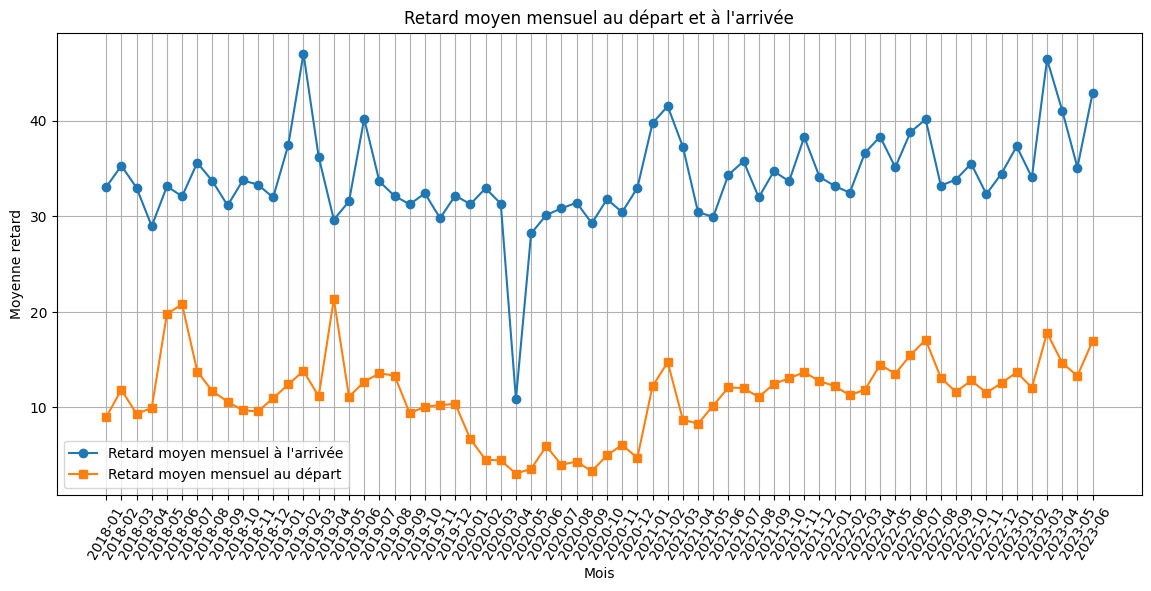

In [144]:
df= data.copy()

# Convert the "date" column to a datetime object with format 'YYYY-MM'
df['date'] = pd.to_datetime(df['date'], format='%Y-%m')


# Group the data by month, calculate the average arrival and departure delays for each month
monthly_mean_arrival_delay = df.groupby(df['date'].dt.to_period('M'))['retard_moyen_arrivee'].mean()
monthly_mean_departure_delay = df.groupby(df['date'].dt.to_period('M'))['retard_moyen_depart'].mean()

# Create an integer range for the x-axis based on the number of data points
x = range(len(monthly_mean_arrival_delay))

# Plot the data on the same plot
plt.figure(figsize=(14, 6))
plt.plot(x, monthly_mean_arrival_delay, label="Retard moyen mensuel à l'arrivée", marker='o')
plt.plot(x, monthly_mean_departure_delay, label='Retard moyen mensuel au départ', marker='s')
plt.title("Retard moyen mensuel au départ et à l'arrivée")
plt.xlabel('Mois')
plt.ylabel('Moyenne retard')
plt.legend()

# Set the x-axis ticks and labels
plt.xticks(x, [d.strftime('%Y-%m') for d in monthly_mean_arrival_delay.index], rotation=60)

plt.grid(True)
plt.show()

In [145]:
df[df['nb_train_depart_retard'] > 0].groupby('gare_depart')['nb_train_depart_retard'].

SyntaxError: invalid syntax (3065338008.py, line 1)

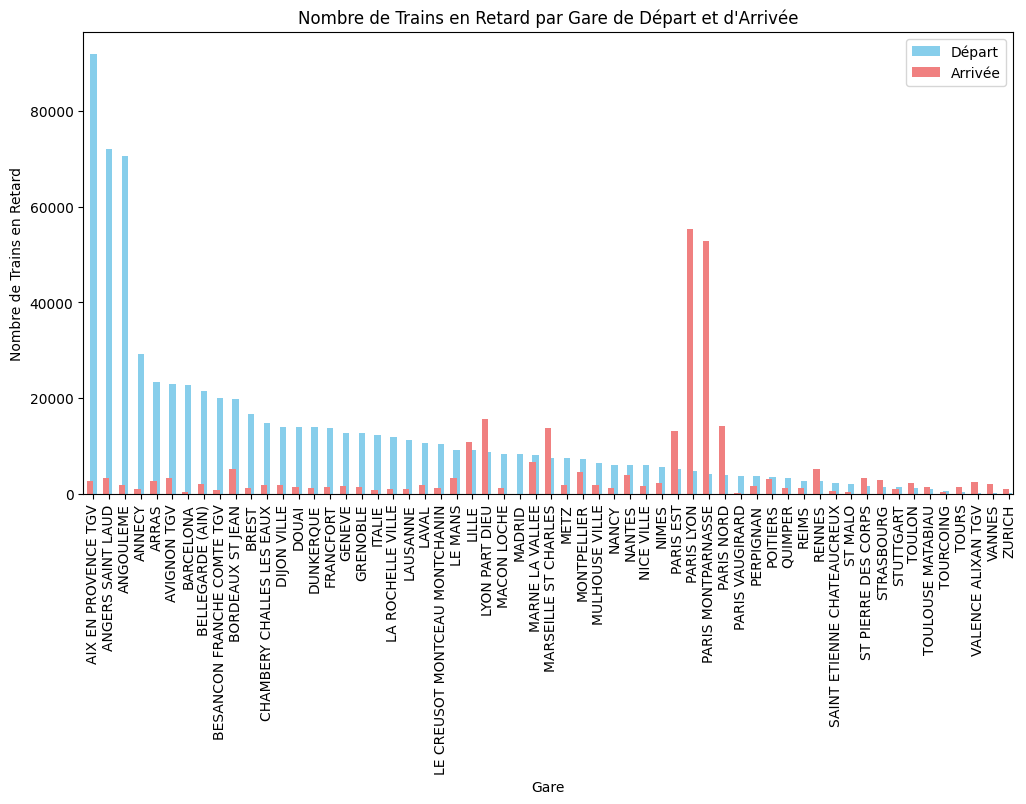

In [ ]:
# Grouper par "gare_depart" et compter le nombre de trains en retard au départ
nombre_trains_retard_depart = df[df['nb_train_depart_retard'] > 0].groupby('gare_depart')['nb_train_depart_retard'].sum()

# Grouper par "gare_arrivee" et compter le nombre de trains en retard à l'arrivée
nombre_trains_retard_arrivee = df[df['nb_train_retard_arrivee'] > 0].groupby('gare_arrivee')['nb_train_retard_arrivee'].sum()

# Triez les gares par le nombre de trains en retard au départ, en ordre décroissant
nombre_trains_retard_depart = nombre_trains_retard_depart.sort_values(ascending=False)

# Créez un graphique en barres
plt.figure(figsize=(12, 6))

# Créez un petit décalage entre les deux barres
width = 0.4

nombre_trains_retard_depart.plot(kind='bar', color='skyblue', label='Départ', width=width)
nombre_trains_retard_arrivee.plot(kind='bar', color='lightcoral', label='Arrivée', width=width, position=1)

plt.title('Nombre de Trains en Retard par Gare de Départ et d\'Arrivée')
plt.xlabel('Gare')
plt.ylabel('Nombre de Trains en Retard')

# Rotation des étiquettes de l'axe des x de 90 degrés
plt.xticks(rotation=90)

# Ajoutez une légende pour distinguer les données de départ et d'arrivée
plt.legend()

plt.show()

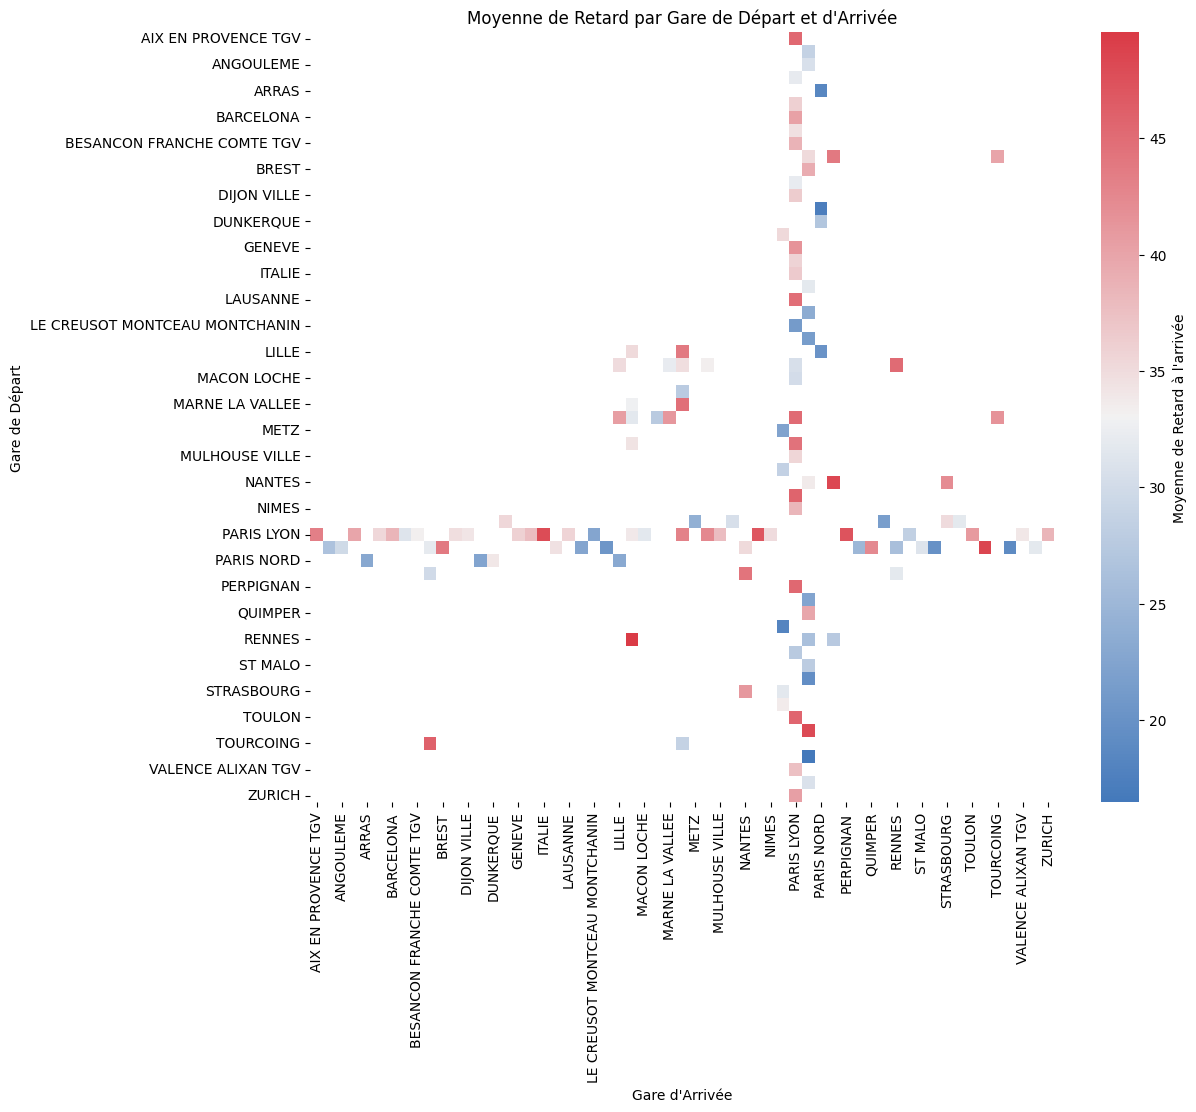

In [ ]:
# Pivot the DataFrame to create a matrix of average delays
pivot_df = df.pivot_table(index='gare_depart', columns='gare_arrivee', values='retard_moyen_arrivee', aggfunc='mean')
stom_cmap = sns.diverging_palette(250, 10, as_cmap=True)
# Create a heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(pivot_df, cmap=stom_cmap, fmt=".1f", cbar_kws={'label': "Moyenne de Retard à l'arrivée"})
# sns.heatmap(pivot_df, cmap='YlGnBu', fmt=".1f", cbar_kws={'label': "Moyenne de Retard à l'arrivée"})
plt.title('Moyenne de Retard par Gare de Départ et d\'Arrivée')
plt.xlabel('Gare d\'Arrivée')
plt.ylabel('Gare de Départ')

plt.show()

C:\Users\wwway\AppData\Local\Temp\ipykernel_13084\1546660234.py:38: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_xticklabels(gares, rotation=90)


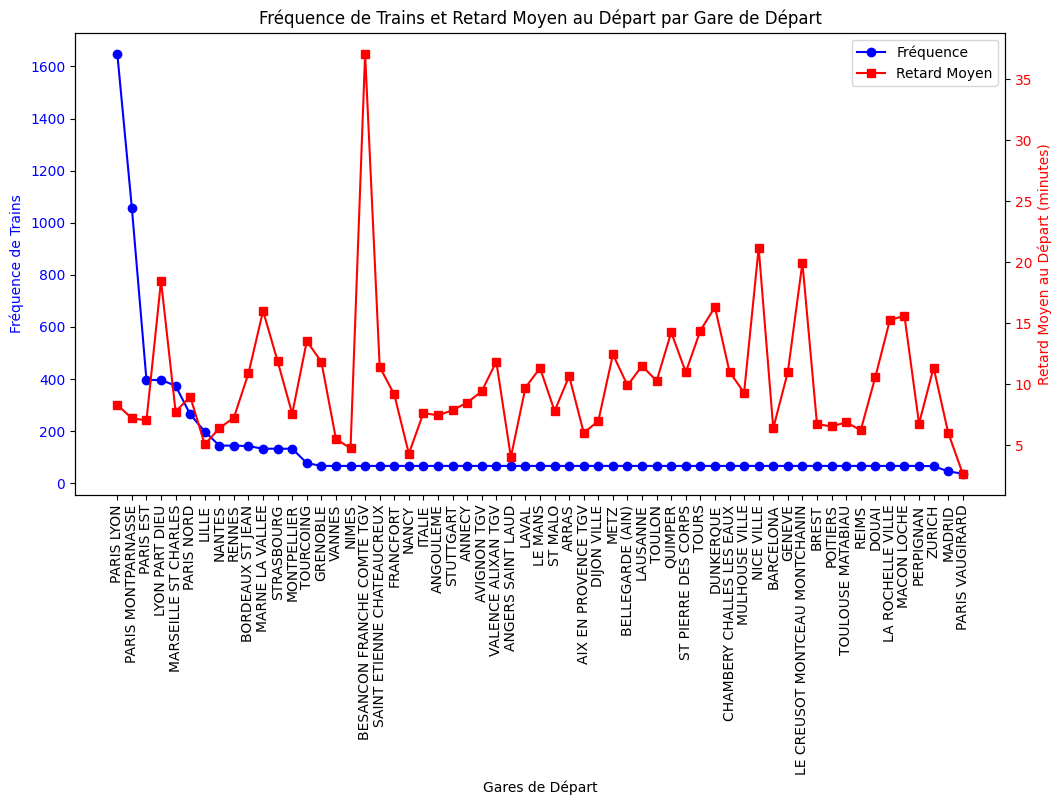

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Supposons que votre DataFrame s'appelle "df"

# Comptez le nombre d'instances par gare de départ
frequence_gare_depart = df['gare_depart'].value_counts()

# Groupez par "gare_depart" et calculez la moyenne du retard au départ
retard_moyen_depart = df.groupby('gare_depart')['retard_moyen_depart'].mean()

# Créez une liste d'abscisses (gares de départ)
gares = frequence_gare_depart.index

# Créez un graphique à deux axes Y distincts
fig, ax1 = plt.subplots(figsize=(12, 6))

# Tracez la première ligne pour la fréquence sur l'axe des Y1
ax1.plot(gares, frequence_gare_depart, color='b', marker='o', label='Fréquence')
ax1.set_xlabel('Gares de Départ')
ax1.set_ylabel('Fréquence de Trains', color='b')
ax1.tick_params(axis='y', labelcolor='b')

# Créez un deuxième axe Y pour le retard moyen
ax2 = ax1.twinx()
ax2.plot(gares, retard_moyen_depart, color='r', marker='s', label='Retard Moyen')
ax2.set_ylabel('Retard Moyen au Départ (minutes)', color='r')
ax2.tick_params(axis='y', labelcolor='r')

plt.title('Fréquence de Trains et Retard Moyen au Départ par Gare de Départ')

# Ajoutez une légende
lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines + lines2, labels + labels2, loc='best')

# Ajoutez cette ligne pour faire pivoter les noms des gares de 90 degrés
ax1.set_xticklabels(gares, rotation=90)

plt.show()


C:\Users\wwway\AppData\Local\Temp\ipykernel_13084\1795640459.py:33: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_xticklabels(gares_arrivee, rotation=90)


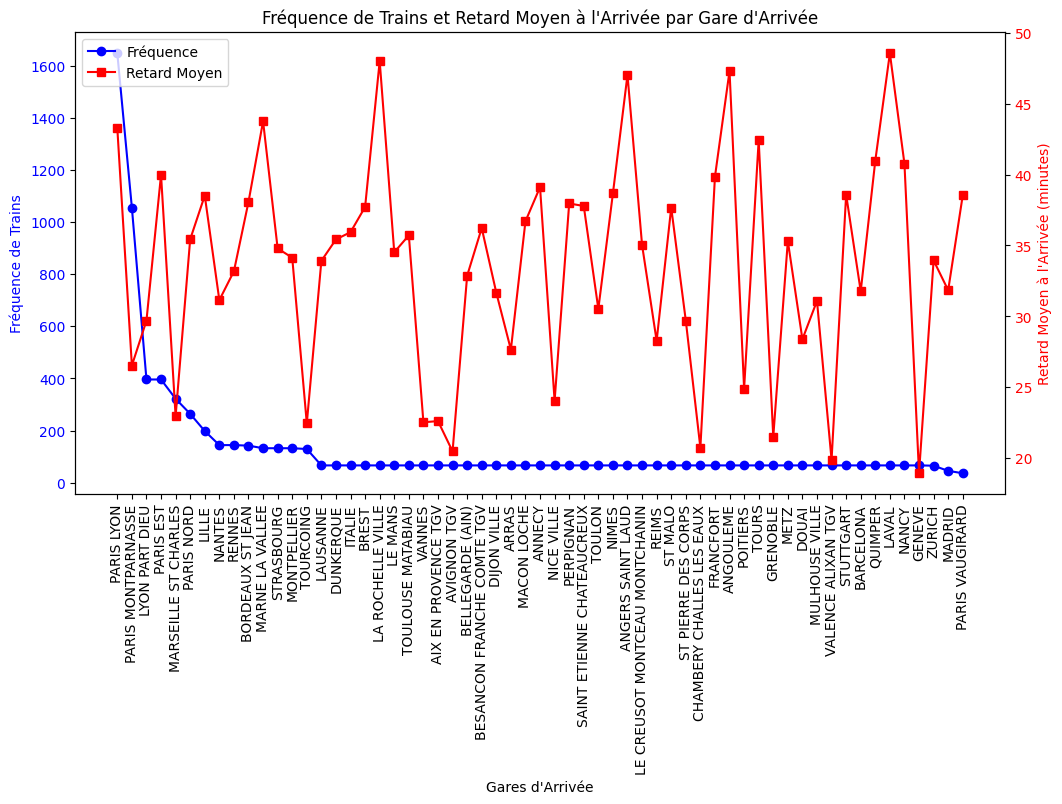

In [ ]:

# Comptez le nombre d'instances par gare d'arrivée
frequence_gare_arrivee = df['gare_arrivee'].value_counts()

# Groupez par "gare_arrivee" et calculez la moyenne du retard à l'arrivée
retard_moyen_arrivee = df.groupby('gare_arrivee')['retard_moyen_arrivee'].mean()

# Créez une liste d'abscisses (gares d'arrivée)
gares_arrivee = frequence_gare_arrivee.index

# Créez un graphique à deux axes Y distincts
fig, ax1 = plt.subplots(figsize=(12, 6))

# Tracez la première ligne pour la fréquence sur l'axe des Y1
ax1.plot(gares_arrivee, frequence_gare_arrivee, color='b', marker='o', label='Fréquence')
ax1.set_xlabel('Gares d\'Arrivée')
ax1.set_ylabel('Fréquence de Trains', color='b')
ax1.tick_params(axis='y', labelcolor='b')

# Créez un deuxième axe Y pour le retard moyen à l'arrivée
ax2 = ax1.twinx()
ax2.plot(gares_arrivee, retard_moyen_arrivee, color='r', marker='s', label='Retard Moyen')
ax2.set_ylabel('Retard Moyen à l\'Arrivée (minutes)', color='r')
ax2.tick_params(axis='y', labelcolor='r')

plt.title('Fréquence de Trains et Retard Moyen à l\'Arrivée par Gare d\'Arrivée')

# Ajoutez une légende
lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines + lines2, labels + labels2, loc='best')

# Ajoutez cette ligne pour faire pivoter les noms des gares d'arrivée de 90 degrés
ax1.set_xticklabels(gares_arrivee, rotation=90)

plt.show()

In [ ]:
# function that extract statistical parameters from a grouby objet:
def get_stats(group):
    return {'min': group.min(), 'max': group.max(),
            'count': group.count(), 'mean': group.mean()}
#_______________________________________________________________
# Creation of a dataframe with statitical infos on each airline:
global_stats = data['retard_moyen_arrivee'].groupby(data['gare_depart']).apply(get_stats).unstack()
global_stats = global_stats.sort_values('mean',ascending=False)
global_stats

min         max   count       mean
gare_depart                                                             
TOULOUSE MATABIAU               20.683333   92.334783    66.0  48.006583
NICE VILLE                       0.000000   75.144203    66.0  45.802248
TOULON                           0.000000   71.945333    66.0  45.550346
AIX EN PROVENCE TGV             23.983333   89.785714    66.0  45.390239
PERPIGNAN                        0.000000   80.692949    66.0  45.310804
LAUSANNE                         0.000000  112.687500    66.0  44.899500
TOURCOING                        0.000000  299.600000    77.0  43.070961
GENEVE                           0.000000   88.898810    66.0  41.519903
ZURICH                           0.000000  147.716667    65.0  40.407253
BARCELONA                        0.000000  122.927778    66.0  40.298323
QUIMPER                         20.166667   81.290196    66.0  39.782916
MONTPELLIER                    -30.512500   68.287778   132.0  39.418299
BREST                           16.500000   78.035417    66.0  39.252674
NANTES                           0.000000  139.545833   144.0  38.811524
MARNE LA VALLEE                  0.000000   77.266667   132.0  38.744310
BESANCON FRANCHE COMTE TGV      14.794444   89.675926    66.0  38.587554
MARSEILLE ST CHARLES             0.000000  190.000000   374.0  38.526968
NIMES                          -40.109259   57.021642    66.0  38.371121
BORDEAUX ST JEAN                 0.000000  119.000000   142.0  38.103614
VALENCE ALIXAN TGV              17.116667   58.375373    66.0  37.504006
PARIS LYON                       0.000000  164.391667  1649.0  37.221917
RENNES                           0.000000  255.866667   144.0  37.024133
ITALIE                           0.000000   61.694697    66.0  36.518952
DIJON VILLE                     16.578333   84.821569    66.0  36.394519
STRASBOURG                       0.000000  112.833333   132.0  36.387377
AVIGNON TGV                     16.127778   80.098148    66.0  36.107694
GRENOBLE                         0.000000  108.351667    66.0  35.741652
MULHOUSE VILLE                  20.953704   81.563889    66.0  35.477046
FRANCFORT                        0.000000   74.201515    66.0  35.333880
PARIS VAUGIRARD                 10.158333  108.300000    36.0  35.306467
LYON PART DIEU                   0.000000  105.181250   396.0  35.154717
BELLEGARDE (AIN)                 0.000000   60.717391    66.0  34.684920
STUTTGART                        0.000000   67.920833    66.0  33.617244
LILLE                            0.000000   79.230159   198.0  32.997946
CHAMBERY CHALLES LES EAUX        0.000000   51.846825    66.0  32.217432
ANNECY                           0.000000   54.809524    66.0  31.985875
LA ROCHELLE VILLE                0.000000   75.917778    66.0  31.752757
VANNES                          15.000000   57.803205    66.0  30.744436
ANGOULEME                       16.042308   53.156173    66.0  30.559323
PARIS MONTPARNASSE               0.000000  114.408333  1056.0  30.526484
MACON LOCHE                     18.287255   53.919792    66.0  30.153217
PARIS EST                        0.000000   82.625000   396.0  29.712262
ANGERS SAINT LAUD               14.872436   47.248309    66.0  28.727275
NANCY                            5.266667   64.083333    66.0  28.597228
ST MALO                          0.000000   60.140476    66.0  27.882174
MADRID                           0.000000  106.030556    45.0  27.785877
SAINT ETIENNE CHATEAUCREUX       0.000000   67.781667    66.0  27.669713
DUNKERQUE                        0.000000   48.587879    66.0  27.049650
PARIS NORD                       0.000000   67.695652   264.0  25.603154
LAVAL                           11.361111   49.873504    66.0  23.557547
POITIERS                        12.075926   39.262579    66.0  22.494823
METZ                            13.878862   40.176543    66.0  22.391746
LE MANS                         10.898397   44.480676    66.0  21.481944
LE CREUSOT MONTCEAU MON

C:\Users\wwway\AppData\Local\Temp\ipykernel_13084\2981846498.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtre['Catégorie de Retard'] = df_filtre['retard_moyen_arrivee'].apply(categoriser_retard)
C:\Users\wwway\AppData\Local\Temp\ipykernel_13084\2981846498.py:29: UserWarning: The palette list has more values (8) than needed (3), which may not be intended.
  sns.countplot(data=df_filtre, y='gare_depart', hue='Catégorie de Retard', order=top_10_gares_depart, palette=palette)


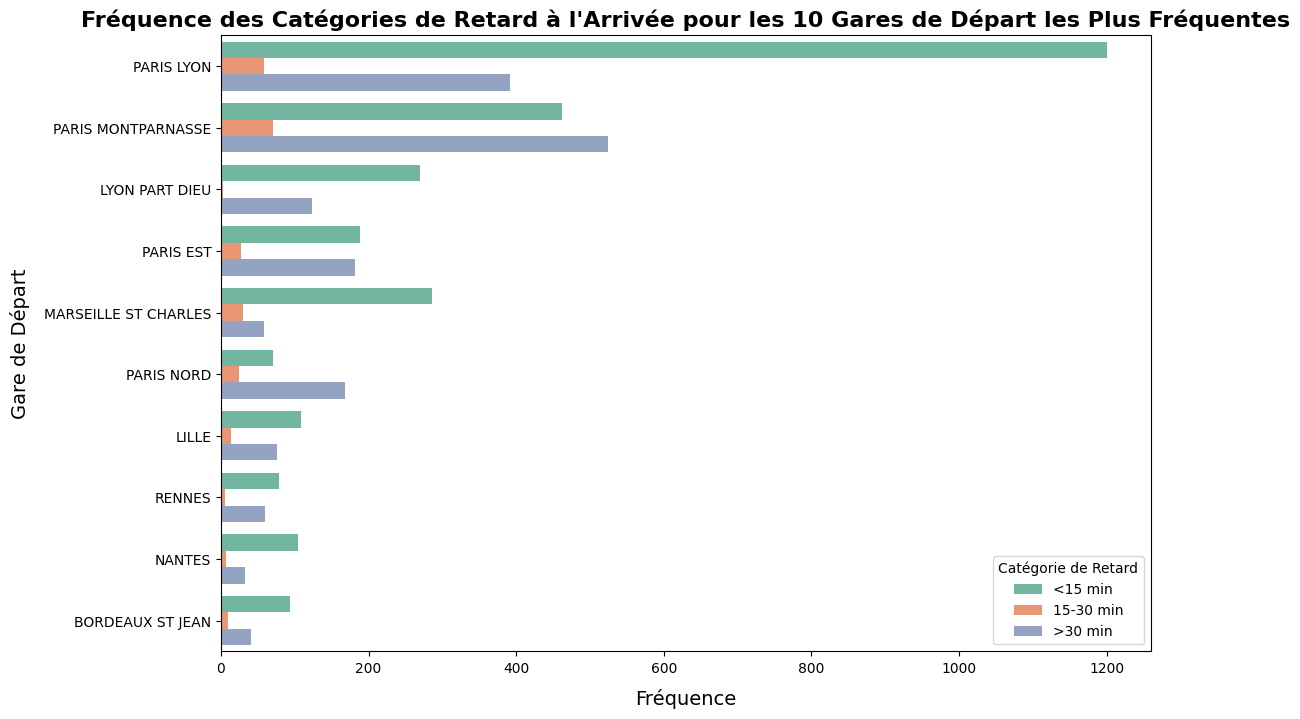

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Remplacez 'votre_dataframe' par le nom de votre DataFrame
votre_dataframe = data

# Obtenir les 10 gares de départ les plus fréquentes
top_10_gares_depart = votre_dataframe['gare_depart'].value_counts().head(10).index

# Filtrer le DataFrame pour les 10 gares de départ les plus fréquentes
df_filtre = votre_dataframe[votre_dataframe['gare_depart'].isin(top_10_gares_depart)]

# Définir une fonction pour catégoriser les retards
def categoriser_retard(retard):
    if retard < 15:
        return '<15 min'
    elif retard < 30:
        return '15-30 min'
    else:
        return '>30 min'

# Appliquer la fonction de catégorisation pour créer une nouvelle colonne 'Catégorie de Retard'
df_filtre['Catégorie de Retard'] = df_filtre['retard_moyen_arrivee'].apply(categoriser_retard)

# Créer un graphique en barres horizontales pour visualiser la fréquence des catégories de retard
plt.figure(figsize=(12, 8))
palette = sns.color_palette("Set2")
sns.countplot(data=df_filtre, y='gare_depart', hue='Catégorie de Retard', order=top_10_gares_depart, palette=palette)
plt.xlabel('Fréquence', fontsize=14, labelpad=10)
plt.ylabel('Gare de Départ', fontsize=14, labelpad=10)
plt.title('Fréquence des Catégories de Retard à l\'Arrivée pour les 10 Gares de Départ les Plus Fréquentes', fontsize=16, fontweight='bold')
plt.legend(title='Catégorie de Retard', labels=['<15 min', '15-30 min', '>30 min'])
plt.show()


C:\Users\wwway\AppData\Local\Temp\ipykernel_13084\4078792241.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_dataframe['Delay_Category'] = filtered_dataframe['retard_moyen_arrivee'].apply(categorize_delay)
C:\Users\wwway\AppData\Local\Temp\ipykernel_13084\4078792241.py:29: UserWarning: The palette list has more values (8) than needed (3), which may not be intended.
  sns.countplot(data=filtered_dataframe, x='gare_depart', hue='Delay_Category', order=top_10_departure_stations, palette=palette)


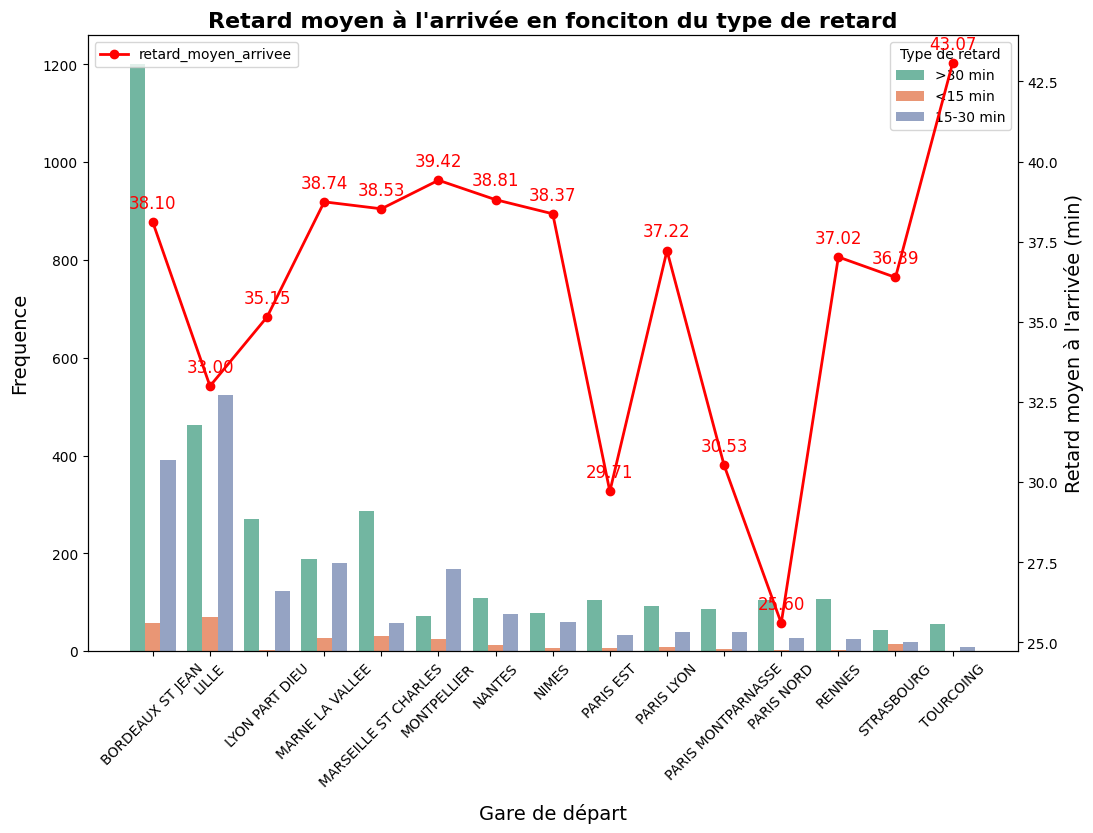

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Replace 'your_dataframe' with the actual name of your DataFrame
your_dataframe = data

# Get the top 10 most frequent departure stations
top_10_departure_stations = your_dataframe['gare_depart'].value_counts().head(15).index

# Filter the DataFrame for the top 10 departure stations
filtered_dataframe = your_dataframe[your_dataframe['gare_depart'].isin(top_10_departure_stations)]

# Define a function to categorize delays
def categorize_delay(delay):
    if delay < 15:
        return '<15 min'
    elif delay < 30:
        return '15-30 min'
    else:
        return '>30 min'

# Apply the categorization function to create a new column 'Delay_Category'
filtered_dataframe['Delay_Category'] = filtered_dataframe['retard_moyen_arrivee'].apply(categorize_delay)

# Create a countplot to visualize the frequency of delay categories for the top 10 departure stations
plt.figure(figsize=(12, 8))
palette = sns.color_palette("Set2")
sns.countplot(data=filtered_dataframe, x='gare_depart', hue='Delay_Category', order=top_10_departure_stations, palette=palette)
plt.xlabel('Gare de départ', fontsize=14, labelpad=10)
plt.ylabel('Frequence', fontsize=14, labelpad=10)
plt.title("Retard moyen à l'arrivée en fonciton du type de retard", fontsize=16, fontweight='bold')
plt.xticks(rotation=45)
plt.legend(title='Type de retard')

# Calculate the average arrival delay for each station
average_arrival_delay = filtered_dataframe.groupby('gare_depart')['retard_moyen_arrivee'].mean()

# Create a line plot for the average arrival delay
plt.twinx()
average_arrival_delay.plot(legend=True, color='red', marker='o', linewidth=2)
plt.ylabel("Retard moyen à l'arrivée (min)", fontsize=14)

# Annotate the data points with their values
for i, val in enumerate(average_arrival_delay):
    plt.annotate(f'{val:.2f}', (i, val), textcoords="offset points", xytext=(0, 10), ha='center', fontsize=12, color='red')

plt.show()


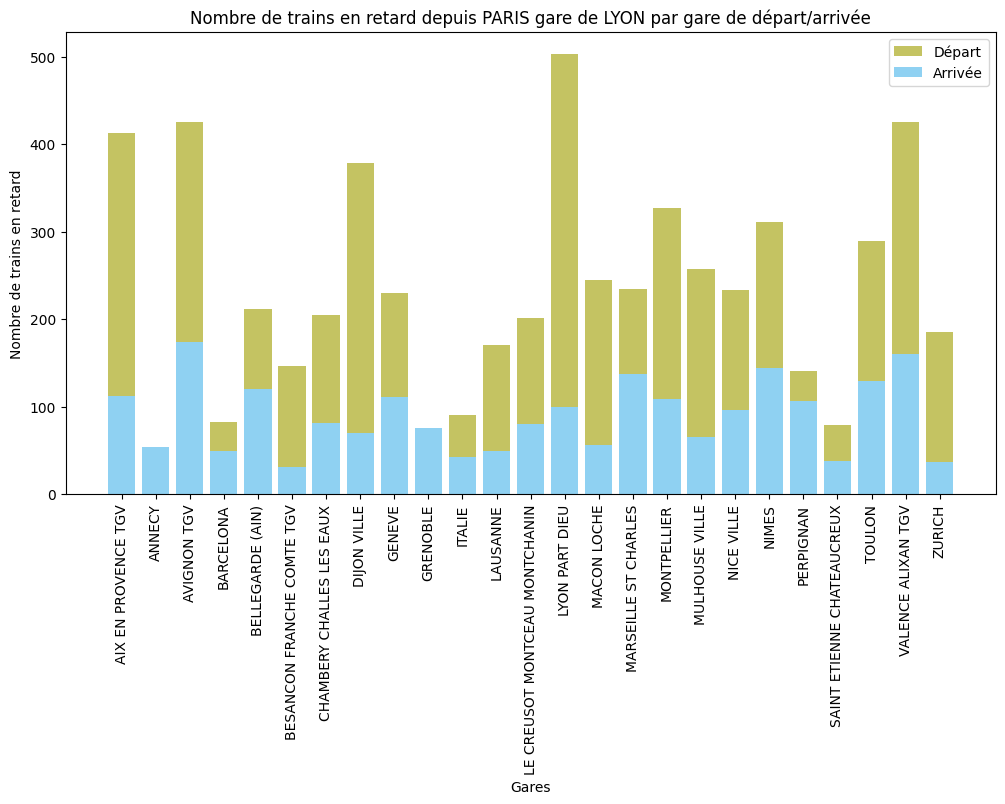

In [ ]:
# Filtrer les données pour Paris Montparnasse (départ et arrivée)
paris_montparnasse_data_depart = data[data['gare_arrivee'] == 'PARIS LYON']
paris_montparnasse_data_arrivee = data[data['gare_depart'] == 'PARIS LYON']

# Trier les données pour les deux cas
paris_montparnasse_data_depart = paris_montparnasse_data_depart.sort_values(by='gare_depart')
paris_montparnasse_data_arrivee = paris_montparnasse_data_arrivee.sort_values(by='gare_arrivee')

# Créer un graphique
plt.figure(figsize=(12, 6))

# Afficher les données de départ en bleu
plt.bar(paris_montparnasse_data_depart['gare_depart'], paris_montparnasse_data_depart['nb_train_depart_retard'], color='#C4C362', label='Départ')

# Afficher les données d'arrivée en vert
plt.bar(paris_montparnasse_data_arrivee['gare_arrivee'], paris_montparnasse_data_arrivee['nb_train_retard_arrivee'], color='#8FD1F2', label='Arrivée')

plt.xlabel('Gares')
plt.ylabel('Nombre de trains en retard')
plt.xticks(rotation=90)  # Rotation des étiquettes pour une meilleure lisibilité
plt.title('Nombre de trains en retard depuis PARIS gare de LYON par gare de départ/arrivée')
plt.legend()  # Ajoutez une légende pour différencier les données de départ et d'arrivée

plt.show()

In [ ]:
from geopy.distance import great_circle

def calculer_distance(coord1, coord2):
    return great_circle(coord1, coord2).kilometers

In [ ]:
# Joignez les informations de gare pour la gare de départ
df_merged = data.merge(gares_info[['libelle', 'x_wgs84', 'y_wgs84']], left_on='gare_depart', right_on='libelle', how='left')
df_merged.rename(columns={'x_WGS84': 'Depart_Latitude', 'y_WGS84': 'Depart_Longitude'}, inplace=True)

# Joignez les informations de gare pour la gare d'arrivée
df_merged = df_merged.merge(gares_info[['libelle', 'x_wgs84', 'y_wgs84']], left_on='gare_arrivee', right_on='libelle', how='left')
df_merged.rename(columns={'w_wgs84': 'Arrivee_Latitude', 'y_wgs84': 'Arrivee_Longitude'}, inplace=True)
#calculer distance
df_merged['Distance_km'] = votre_dataframe.apply(
    lambda row: calculer_distance((row['Depart_Latitude'], row['Depart_Longitude']), (row['Arrivee_Latitude'], row['Arrivee_Longitude'])),
    axis=1
)

df_merged

In [ ]:
n = data.shape[0]
data.isnull().sum()*100/n

In [ ]:
#Info sur les types des données du dataset (float, int, object)
print(data.dtypes)

In [ ]:
#Info sur chaque colonne du dataset
print(data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8154 entries, 0 to 8153
Data columns (total 26 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   date                                  8154 non-null   object 
 1   service                               8154 non-null   object 
 2   gare_depart                           8154 non-null   object 
 3   gare_arrivee                          8154 non-null   object 
 4   duree_moyenne                         8154 non-null   int64  
 5   nb_train_prevu                        8154 non-null   int64  
 6   nb_annulation                         8154 non-null   int64  
 7   commentaire_annulation                0 non-null      float64
 8   nb_train_depart_retard                8154 non-null   int64  
 9   retard_moyen_depart                   8154 non-null   float64
 10  retard_moyen_tous_trains_depart       8154 non-null   float64
 11  commentaire_retar

In [ ]:
#On convertit la colonne 'date' du DataFrame en un format de date spécifique (année-mois)
#en utilisant la fonction pd.to_datetime, et on crée une nouvelle colonne "année" pour faciliter le split
data['date'] = pd.to_datetime(data['date'])
data['annee'] = data['date'].dt.year
data

In [ ]:
data[data["prct_cause_infra"]==100].prct_cause_infra.count()
data[data["prct_cause_infra"]>50].prct_cause_infra.count()



305

In [ ]:
list(data.columns)

['date',
 'service',
 'gare_depart',
 'gare_arrivee',
 'duree_moyenne',
 'nb_train_prevu',
 'nb_annulation',
 'commentaire_annulation',
 'nb_train_depart_retard',
 'retard_moyen_depart',
 'retard_moyen_tous_trains_depart',
 'commentaire_retards_depart',
 'nb_train_retard_arrivee',
 'retard_moyen_arrivee',
 'retard_moyen_tous_trains_arrivee',
 'commentaires_retard_arrivee',
 'nb_train_retard_sup_15',
 'retard_moyen_trains_retard_sup15',
 'nb_train_retard_sup_30',
 'nb_train_retard_sup_60',
 'prct_cause_externe',
 'prct_cause_infra',
 'prct_cause_gestion_trafic',
 'prct_cause_materiel_roulant',
 'prct_cause_gestion_gare',
 'prct_cause_prise_en_charge_voyageurs',
 'Total Voyageurs annuel',
 'Total Voyageurs + non voyageurs annuel']

In [ ]:
df=data[[
 'nb_train_depart_retard',
 "nb_train_prevu",
 'nb_annulation',
 "nb_train_retard_sup_15",
 "retard_moyen_trains_retard_sup15",
 "nb_train_retard_sup_30", 
 "nb_train_retard_sup_60",
 "duree_moyenne",
 'retard_moyen_depart',
 'retard_moyen_tous_trains_depart',
 'nb_train_retard_arrivee',
 'retard_moyen_arrivee',
 'retard_moyen_tous_trains_arrivee','Total Voyageurs annuel',
 'Total Voyageurs + non voyageurs annuel'
]]

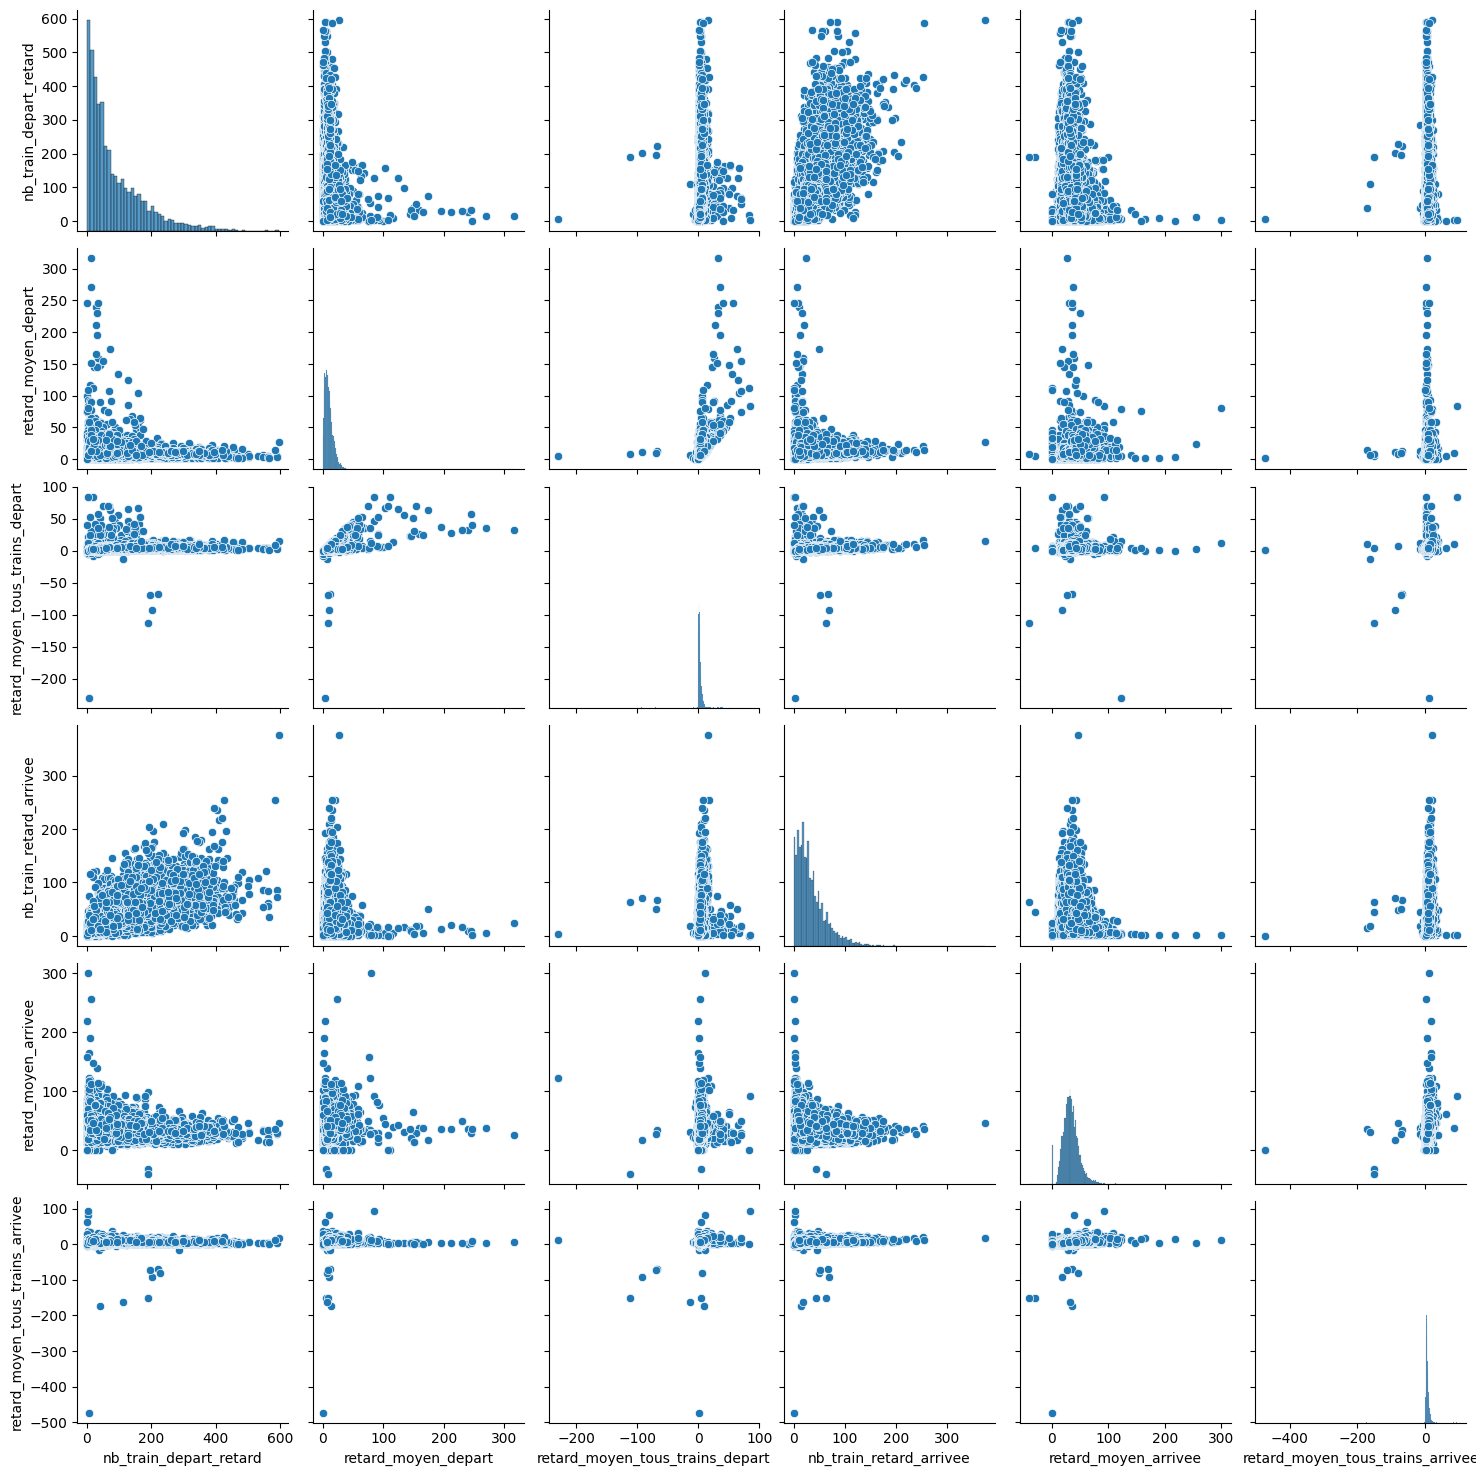

In [ ]:
sns.pairplot(data[[
 'nb_train_depart_retard',
 'retard_moyen_depart',
 'retard_moyen_tous_trains_depart',
 'nb_train_retard_arrivee',
 'retard_moyen_arrivee',
 'retard_moyen_tous_trains_arrivee',
]])

<Axes: xlabel='retard_moyen_arrivee', ylabel='retard_moyen_tous_trains_arrivee'>

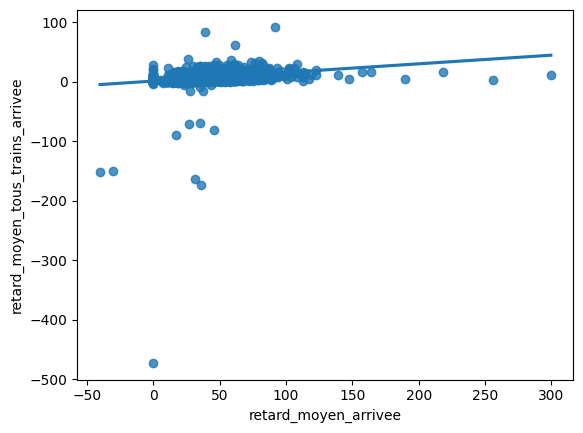

In [ ]:
sns.regplot(data=data, x="retard_moyen_arrivee", y="retard_moyen_tous_trains_arrivee", ci=None)

# Matrice de corrélation

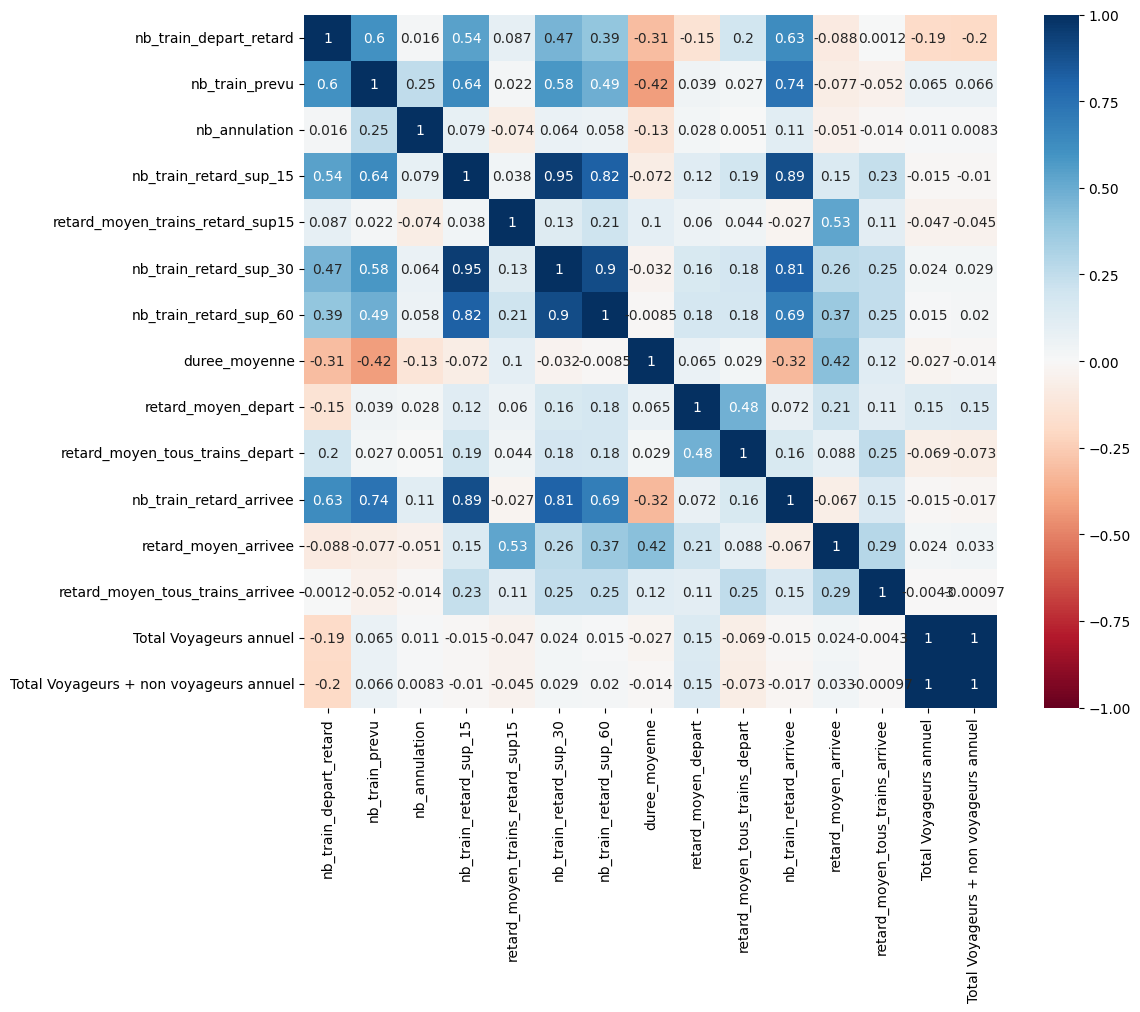

In [ ]:
plt.figure(figsize=(12, 9))
# Store heatmap object in a variable to easily access it when you want to include more features (such as title).
# Set the range of values to be displayed on the colormap from -1 to 1, and set the annotation to True to display the correlation values on the heatmap.
colormap = plt.cm.RdBu
heatmap = sns.heatmap(df.corr(), vmin=-1,square=True, cmap=colormap, vmax=1, annot=True)
# Give a title to the heatmap. Pad defines the distance of the title from the top of the heatmap.

In [ ]:
#from sklearn.preprocessing import MinMaxScaler
#import pandas as pd

#data.head()
 
#scaler = MinMaxScaler()
 

## to set the plot size 
#plt.figure(figsize=(16, 8), dpi=150) 
  
## using plot method to plot open prices. 
## in plot method we set the label and color of the curve. 
#df=data[["retard_moyen_depart","retard_moyen_arrivee"]]
#dfa=df
#df.index = data['date'].dt.to_period('M')
#df_scaled = scaler.fit_transform(dfa.to_numpy())
#df_scaled = pd.DataFrame(df_scaled, columns=["retard_moyen_depart","retard_moyen_arrivee"])
#df["retard_moyen_depart"]=df_scaled["retard_moyen_depart"]
#df["retard_moyen_arrivee"]=df_scaled["retard_moyen_arrivee"]
#df['retard_moyen_arrivee'].plot(label='arrive', color='orange') 
#df['retard_moyen_depart'].plot(label='dedpart') 

  
## adding title to the plot 
#plt.title('Visualization') 
  
## adding Label to the x-axis 
#plt.xlabel('Years') 

## adding legend to the curve 
#plt.legend()

AttributeError: Can only use .dt accessor with datetimelike values

<Figure size 2400x1200 with 0 Axes>

In [ ]:
#Infos sur le nombre de valeurs nulles (manquantes) dans le dataset
print(data.isnull().sum())

date                                       0
service                                    0
gare_depart                                0
gare_arrivee                               0
duree_moyenne                              0
nb_train_prevu                             0
nb_annulation                              0
commentaire_annulation                  8154
nb_train_depart_retard                     0
retard_moyen_depart                        0
retard_moyen_tous_trains_depart            0
commentaire_retards_depart              8154
nb_train_retard_arrivee                    0
retard_moyen_arrivee                       0
retard_moyen_tous_trains_arrivee           0
commentaires_retard_arrivee             7456
nb_train_retard_sup_15                     0
retard_moyen_trains_retard_sup15           0
nb_train_retard_sup_30                     0
nb_train_retard_sup_60                     0
prct_cause_externe                         0
prct_cause_infra                           0
prct_cause

In [ ]:
data.columns

Index(['date', 'service', 'gare_depart', 'gare_arrivee', 'duree_moyenne',
       'nb_train_prevu', 'nb_annulation', 'commentaire_annulation',
       'nb_train_depart_retard', 'retard_moyen_depart',
       'retard_moyen_tous_trains_depart', 'commentaire_retards_depart',
       'nb_train_retard_arrivee', 'retard_moyen_arrivee',
       'retard_moyen_tous_trains_arrivee', 'commentaires_retard_arrivee',
       'nb_train_retard_sup_15', 'retard_moyen_trains_retard_sup15',
       'nb_train_retard_sup_30', 'nb_train_retard_sup_60',
       'prct_cause_externe', 'prct_cause_infra', 'prct_cause_gestion_trafic',
       'prct_cause_materiel_roulant', 'prct_cause_gestion_gare',
       'prct_cause_prise_en_charge_voyageurs'],
      dtype='object')

In [ ]:
data.retard_moyen_depart.describe()

count    8154.000000
mean       11.205745
std        12.476780
min         0.000000
25%         5.128410
50%         9.036447
75%        14.219375
max       316.188095
Name: retard_moyen_depart, dtype: float64

In [ ]:
df=data[data.retard_moyen_depart>80]
df[["retard_moyen_depart","retard_moyen_arrivee"]].sort_values(by="retard_moyen_arrivee", ascending=False)
df["difference"]=df.retard_moyen_arrivee-df.retard_moyen_depart
df[["retard_moyen_depart","retard_moyen_arrivee",'difference']].sort_values(by="retard_moyen_arrivee", ascending=False)


C:\Users\wwway\AppData\Local\Temp\ipykernel_24628\989629730.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["difference"]=df.retard_moyen_arrivee-df.retard_moyen_depart


retard_moyen_depart  retard_moyen_arrivee  difference
4306            84.516667             92.000000    7.483333
7692            89.615385             81.290196   -8.325189
1124            93.000000             76.983333  -16.016667
2114           148.767094             64.600000  -84.167094
538             99.200000             55.000000  -44.200000
2140           229.726111             50.497059 -179.229052
2153           103.524473             44.761111  -58.763361
2177           125.125459             42.738889  -82.386570
2000           116.554167             40.250000  -76.304167
2219           159.658081             38.316667 -121.341414
2029           270.438095             37.883333 -232.554762
2828           166.168519             37.280556 -128.887963
2361           144.598413             36.422727 -108.175685
2713           211.662963             35.899167 -175.763796
3755           246.383333             35.750000 -210.633333
1964           239.678395             35.594444 -204.083951
2364           196.210556             35.506410 -160.704145
1978           134.467010             30.485294 -103.981716
2404            85.458984             29.991667  -55.467318
2465           245.081313             29.416667 -215.664646
1948            92.140889             29.055882  -63.085007
2265           153.911667             28.834259 -125.077407
2508           316.188095             27.000694 -289.187401
2833           107.583092             25.451042  -82.132050
2554           145.385938             20.981481 -124.404456
3066            90.796250             20.978571  -69.817679
1987           173.722603             18.452667 -155.269936
2977           151.529762             15.020833 -136.508929
2958            92.274074             13.491667  -78.782407
3722           111.498148              0.000000 -111.498148
4688           108.733333              0.000000 -108.733333

In [ ]:
df